In [ ]:
import tensorflow as tf
import os
tf.__version__

'2.8.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path='/content/drive/MyDrive/dt_2'
train_path='/content/drive/MyDrive/dt_2/train'
train_normal_path='/content/drive/MyDrive/dt_2/train/Normal'
train_osteoporosis_path='/content/drive/MyDrive/dt_2/train/Osteoporosis'
validation_path='/content/drive/MyDrive/dt_2/val'
validation_normal_path='/content/drive/MyDrive/dt_2/val/Normal'
validation_osteoporosis_path='/content/drive/MyDrive/dt_2/val/Osteoporosis'
test_path='/content/drive/MyDrive/dt_2/test'
test_normal_path='/content/drive/MyDrive/dt_2/test/Normal'
test_osteoporosis_path='/content/drive/MyDrive/dt_2/test/Osteoporosis'

In [ ]:
train_images = []
train_labels = [] 

In this block we are appending our images with there respective labels to the list and also resizing them to 224,224.

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
for directory_path in os.listdir(train_path):
    label = directory_path.split("\\")[-1]
    for img_path in  glob.glob(os.path.join(train_path,directory_path, "*")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)     
        img = cv2.resize(img, (224, 224))
        train_images.append(img)
        train_labels.append(label)

In [ ]:
for directory_path in os.listdir(validation_path):
    label = directory_path.split("\\")[-1]
    for img_path in  glob.glob(os.path.join(train_path,directory_path, "*")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)     
        img = cv2.resize(img, (224, 224))
        train_images.append(img)
        train_labels.append(label)

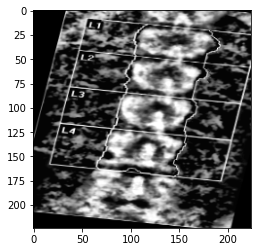

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(train_images[0],cmap="gray")

In [ ]:
train_images[0].shape

(224, 224)

Converting our list to numpy arrays.

In [ ]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
test_images = []
test_labels = [] 

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
for directory_path in os.listdir(test_path):
    label = directory_path.split("\\")[-1]
    for img_path in  glob.glob(os.path.join(test_path,directory_path, "*")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)    
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)     
        img = cv2.resize(img, (224, 224))
        test_images.append(img)
        test_labels.append(label)

In [ ]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)

Here we are changing our label names Normal,Osteoporosis to Zero and One.

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [ ]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

We are Normalizing Every image to be in the range of zero to One

In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

We are Doing One Hot Encoding Which Heps Us to Increase accuracy.

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

Importing VGG16 and making include_top as false for doing only feature extraction.

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
IMAGE_SIZE = [224, 224,3]
vgg_model = VGG16(input_shape=IMAGE_SIZE,include_top=False, weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg_config = vgg_model.get_config()

Converting the number of Channels to one because we are dealing with grayscale images.

In [ ]:
h, w, c = 224, 224, 1
vgg_config["layers"][0]["config"]["batch_input_shape"] = (None, h, w, c)

In [ ]:
from tensorflow.keras.models import Model
vgg_updated = Model.from_config(vgg_config)

This Function returns the average of all the r,g,b channels weights to one channel

In [ ]:
def avg_wts(weights):  
  average_weights = np.mean(weights, axis=-2).reshape(weights[:,:,-1:,:].shape)  
  return(average_weights)

Here we are assigning our First Conv channel to first_conv_name

In [ ]:
vgg_updated_config = vgg_updated.get_config()
vgg_updated_layer_names = [vgg_updated_config['layers'][x]['name'] for x in range(len(vgg_updated_config['layers']))]
first_conv_name = vgg_updated_layer_names[1]

IN this block we are looping over vgg channels and in each channel we are making them as non trainable and on the first conv block we are applying the avg_wts function

In [ ]:
for layer in vgg_model.layers:
    if layer.name in vgg_updated_layer_names:
     
      if layer.get_weights() != []:
        target_layer = vgg_updated.get_layer(layer.name)
    
        if layer.name in first_conv_name: 
          weights = layer.get_weights()[0]
          biases  = layer.get_weights()[1]
          
          weights_single_channel = avg_wts(weights)
                                                    
          target_layer.set_weights([weights_single_channel, biases]) 
          target_layer.trainable = False  
    
        else:
          target_layer.set_weights(layer.get_weights())    
          target_layer.trainable = False  

In [ ]:
new_model_conv1_block1_wts_updated = vgg_updated.layers[1].get_weights()[0]
print(new_model_conv1_block1_wts_updated[:,:,0,0])

[[ 0.48662183  0.40736297 -0.06929757]
 [ 0.31032872  0.04317178 -0.40803602]
 [-0.05565825 -0.29271564 -0.4178811 ]]


In [ ]:
from tensorflow.keras import Sequential
model_1 = Sequential()
model_1.add(vgg_updated)

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14713536  
                                                                 
Total params: 14,713,536
Trainable params: 0
Non-trainable params: 14,713,536
_________________________________________________________________


We are extracting features from the our train images by our model and reshaping them to a 1D Vector.

In [ ]:
feature_extractor=model_1.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

In [ ]:
X_for_RF = features

Creating random forest classifier with 100 decision trees.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 100, random_state = 42)

We are fitting our train data values that we extracted from our model to fit on the random classifier

In [ ]:
RF_model.fit(X_for_RF, y_train)

RandomForestClassifier(random_state=42)

Same as train dataset we are extracting the features on our test dataset.

In [ ]:
X_test_feature = model_1.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)


We are using our randomclassifer model and doing prediciton on our test dataset.

In [ ]:
prediction_RF = RF_model.predict(X_test_features)
y_pred=prediction_RF

We are using inverse_transform on our predicted values to make them to have Normal,Osteoporosis.

In [ ]:
prediction_RF = le.inverse_transform(prediction_RF)

This is the accuracy of our model.

In [ ]:

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Accuracy =  0.949238578680203


we are using confusion matrix to better understand how our model is prediciting

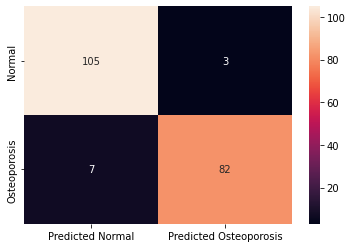

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import pandas as pd

cm = pd.DataFrame(data=confusion_matrix(test_labels, prediction_RF),index=[ "Normal", "Osteoporosis"],
                  columns=["Predicted Normal", "Predicted Osteoporosis"])
#print(cm)
sns.heatmap(cm, annot=True,fmt="d")

This is the roc curve of our Model.

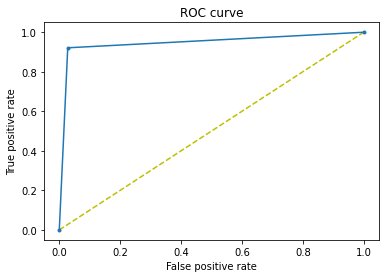

In [ ]:
from sklearn.metrics import roc_curve
y_preds = y_pred.ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [ ]:
from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

Area under curve, AUC =  0.9467852684144819


In [ ]:
print(classification_report(y_true=y_test,y_pred=y_pred,target_names =['NORMAL','Osteoporosis']))

              precision    recall  f1-score   support

      NORMAL       0.94      0.97      0.95       108
Osteoporosis       0.96      0.92      0.94        89

    accuracy                           0.95       197
   macro avg       0.95      0.95      0.95       197
weighted avg       0.95      0.95      0.95       197

